In [2]:
import pandas as pd
from dataclasses import dataclass
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import networkx as nx


In [3]:
@dataclass
class UserInfo:
    uid: int
    subreddit: str
    nposts: int
    target1: bool
    target2: bool

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
target_subreddits = ['technology', 'datascience']

In [6]:
inpath='../sample_file.jsonl'

user_info_list = []
with open(inpath, 'r') as f:
    for line in f:
        data = pd.read_json(line, typ='series')
        targets = []
        for target in target_subreddits:
            targets.append(target in data['reddits'])
        for subreddit, nposts in data['reddits'].items():
            user_info_list.append(UserInfo(uid=data['uid'], subreddit=subreddit, nposts=nposts, target1=targets[0], target2=targets[1]))
data = pd.DataFrame(user_info_list)
print(data.head())

   uid    subreddit  nposts  target1  target2
0    1       python       7    False     True
1    1  datascience      13    False     True
2    1        books      19    False     True
3    1         news       2    False     True
4    1  photography      18    False     True


Text(0.5, 1.0, 'Top 10 Most Frequent Subreddits')

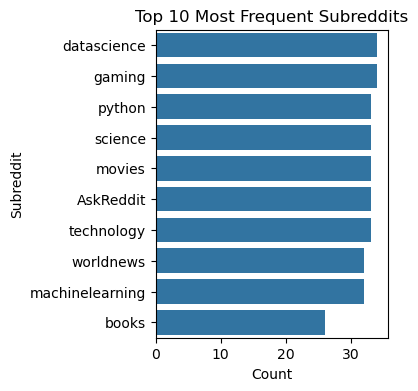

In [7]:
top_subreddits = data['subreddit'].value_counts().head(10)
fig, ax = plt.subplots(figsize=(3, 4))
sns.barplot(x=top_subreddits.values, y=top_subreddits.index, ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Subreddit')
ax.set_title('Top 10 Most Frequent Subreddits')

In [8]:
# Group by 'uid' and aggregate subreddits into tuples
user_subreddit_tuples = defaultdict(int)
for _, row in data.groupby('uid'):
    subreddits = sorted(row['subreddit'].unique())
    for i,r1 in enumerate(subreddits[-1:]):
        for r2 in subreddits[i+1:]:
            if r1 == r2:
                continue
            subreddits = (r1, r2)
            user_subreddit_tuples[subreddits] += 1
most_common_tuple = max(user_subreddit_tuples, key=user_subreddit_tuples.get)
most_common_count = user_subreddit_tuples[most_common_tuple]
print(f"Most common tuple of subreddits: {most_common_tuple} (count: {most_common_count})")

Most common tuple of subreddits: ('technology', 'datascience') (count: 30)


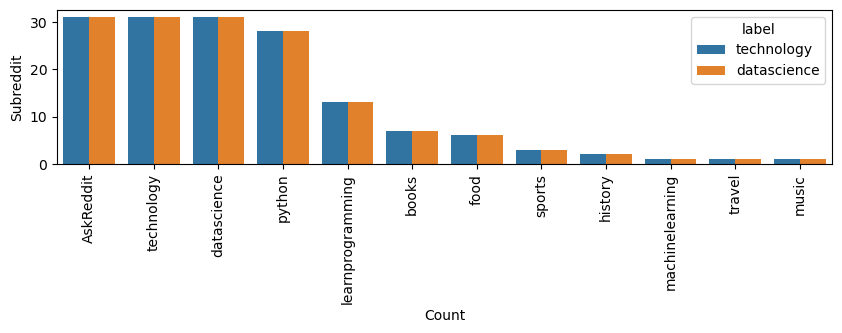

In [9]:
_data = data[data['target1'] & data['target2']]
_df = _data[_data['target1']].groupby('subreddit').size().reset_index()
_df.rename(columns={0: 'count'}, inplace=True)
_df['label'] = target_subreddits[0]
_df2 = _data[_data['target2']].groupby('subreddit').size().reset_index()
_df2.rename(columns={0: 'count'}, inplace=True)
_df2['label'] = target_subreddits[1]
_df = pd.concat([_df, _df2], axis=0).reset_index().rename(columns={0: 'count'})
_df.sort_values('count', ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(10, 2))
sns.barplot(x='subreddit', y='count', hue='label', data=_df, ax=ax)
ax.set_xlabel('Count')
ax.set_ylabel('Subreddit')
_ = plt.xticks(rotation=90)

In [10]:

G = nx.Graph()
for (sub1, sub2), weight in user_subreddit_tuples.items():
    G.add_edge(sub1, sub2, weight=weight)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 19 nodes and 63 edges.


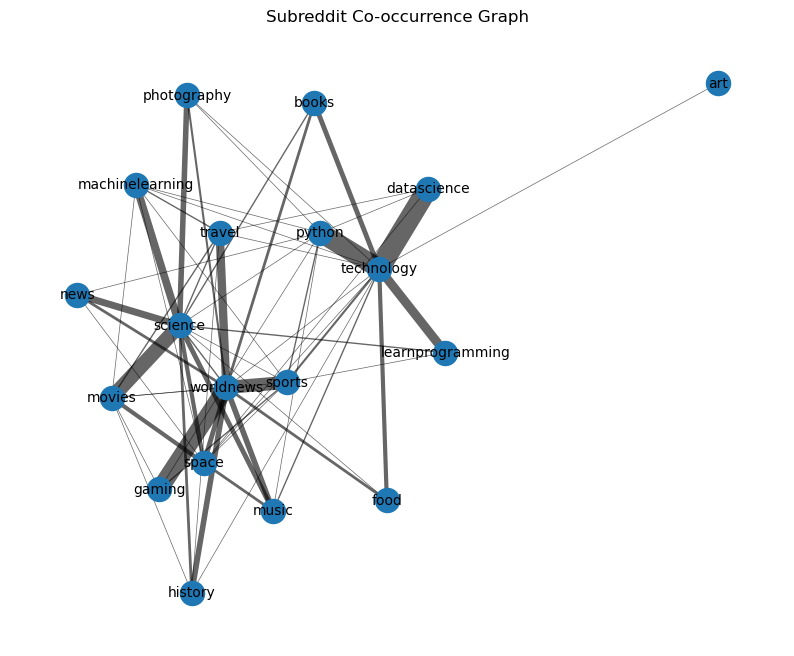

In [11]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42)
weights = [G[u][v]['weight'] for u, v in G.edges()]
nx.draw_networkx_nodes(G, pos, node_size=300)
nx.draw_networkx_edges(G, pos, width=[w/2 for w in weights], alpha=0.6)
nx.draw_networkx_labels(G, pos, font_size=10)
plt.title("Subreddit Co-occurrence Graph")
plt.axis('off')
plt.show()

In [12]:
B = nx.Graph()
# Add user nodes with bipartite=0 and subreddit nodes with bipartite=1
B.add_nodes_from(data['uid'].unique(), bipartite=0)
B.add_nodes_from(data['subreddit'].unique(), bipartite=1)
# Add edges between users and subreddits
edges = list(zip(data['uid'], data['subreddit']))
B.add_edges_from(edges)
print(f"Bigraph has {B.number_of_nodes()} nodes and {B.number_of_edges()} edges.")

Bigraph has 120 nodes and 505 edges.


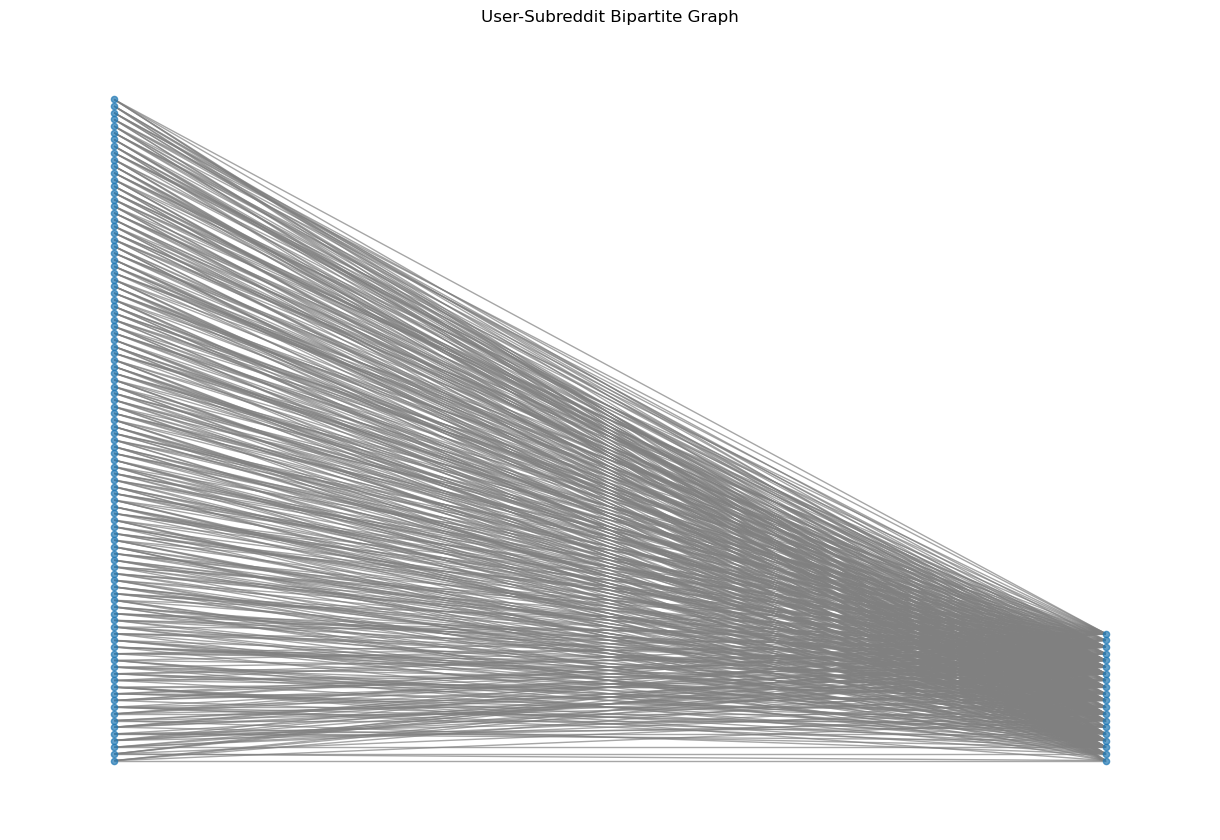

In [13]:
from networkx.algorithms import bipartite

plt.figure(figsize=(12, 8))
# Separate nodes by bipartite set
user_nodes = {n for n, d in B.nodes(data=True) if d['bipartite'] == 0}
subreddit_nodes = set(B) - user_nodes
# Layout for bipartite graph
pos = dict()
pos.update((n, (1, i)) for i, n in enumerate(user_nodes))
pos.update((n, (2, i)) for i, n in enumerate(subreddit_nodes))
nx.draw(B, pos, with_labels=False, node_size=20, edge_color='gray', alpha=0.7)
plt.title("User-Subreddit Bipartite Graph")
plt.show()

In [14]:
user_sub_matrix = data.pivot_table(index='uid', columns='subreddit', values='nposts', aggfunc='sum', fill_value=0)
user_sub_matrix = (user_sub_matrix > 0).astype(int)
user_sub_matrix.head()

subreddit,AskReddit,art,books,datascience,food,gaming,history,learnprogramming,machinelearning,movies,music,news,photography,python,science,space,sports,technology,travel,worldnews
uid,,,,,,,,,,,,,,,,,,,,
1,0,0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,0
3,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1


In [17]:
user_graphs = user_sub_matrix.dot(user_sub_matrix.T)
user_similarity_graph = nx.Graph()
for i, uid1 in enumerate(user_graphs.index):
    for j, uid2 in enumerate(user_graphs.columns):
        if i < j and user_graphs.iloc[i, j] > 0:
            user_similarity_graph.add_edge(uid1, uid2, weight=user_graphs.iloc[i, j])
print(f"User similarity graph has {user_similarity_graph.number_of_nodes()} nodes and {user_similarity_graph.number_of_edges()} edges.")

User similarity graph has 100 nodes and 2775 edges.


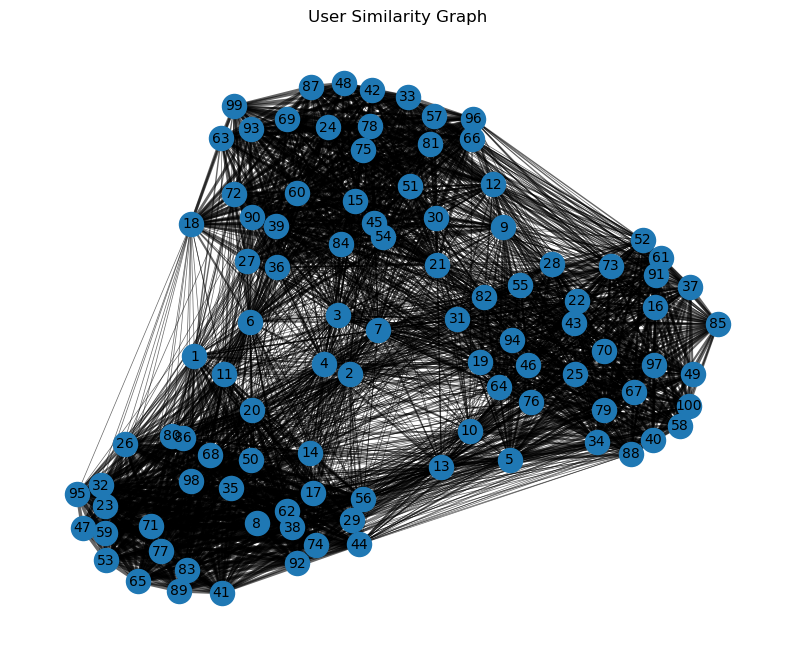

In [21]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(user_similarity_graph, seed=42)
weights = [user_similarity_graph[u][v]['weight'] for u, v in user_similarity_graph.edges()]
nx.draw_networkx_nodes(user_similarity_graph, pos, node_size=300)
nx.draw_networkx_edges(user_similarity_graph, pos, width=[w/2 for w in weights], alpha=0.6)
nx.draw_networkx_labels(user_similarity_graph, pos, font_size=10)
plt.title("User Similarity Graph")
plt.axis('off')
plt.show()

In [20]:
subreddit_graph = user_sub_matrix.T.dot(user_sub_matrix)
subreddit_similarity_graph = nx.Graph()
for i, sub1 in enumerate(subreddit_graph.index):
    for j, sub2 in enumerate(subreddit_graph.columns):
        if i < j and subreddit_graph.iloc[i, j] > 0:
            subreddit_similarity_graph.add_edge(sub1, sub2, weight=subreddit_graph.iloc[i, j])
print(f"Subreddit similarity graph has {subreddit_similarity_graph.number_of_nodes()} nodes and {subreddit_similarity_graph.number_of_edges()} edges.")

Subreddit similarity graph has 20 nodes and 160 edges.


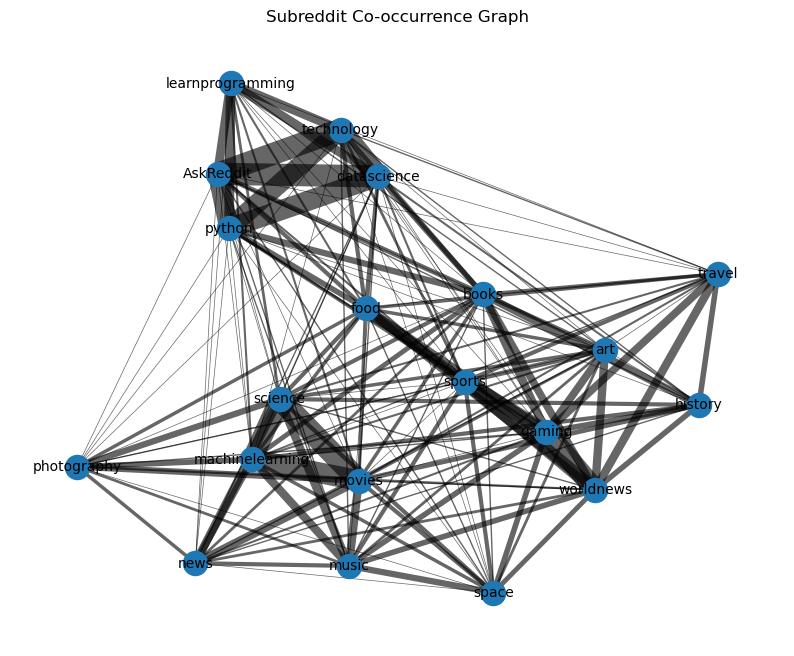

In [22]:
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subreddit_similarity_graph, seed=42)
weights = [subreddit_similarity_graph[u][v]['weight'] for u, v in subreddit_similarity_graph.edges()]
nx.draw_networkx_nodes(subreddit_similarity_graph, pos, node_size=300)
nx.draw_networkx_edges(subreddit_similarity_graph, pos, width=[w/2 for w in weights], alpha=0.6)
nx.draw_networkx_labels(subreddit_similarity_graph, pos, font_size=10)
plt.title("Subreddit Co-occurrence Graph")
plt.axis('off')
plt.show()